In [1]:
import numpy as np
import jax
import flax.linen as nn
import qutip as qt
import matplotlib.pyplot as plt

import pickle

import netket as nk
import nqxpack

from tqdm.auto import tqdm
from glob import glob

import bridge

should be able to remove

In [2]:
class ReshaperNetwork(nn.Module):
    base_net: nn.Module
    @nn.compact
    def __call__(self, samples):
        batch_shape = samples.shape[:-1]
        samples = samples.reshape(-1, samples.shape[-1])
        flat_output = self.base_net(samples)
        return flat_output.reshape(batch_shape)

In [4]:
# Sampling parameters
n_samples = 3000
sweep_size = 40
n_chains = 20
n_discard_per_chain = 100

# Hamiltonian parameters
J = 1.
hc = 3.044 * J
h_factor = 2.0
h = h_factor * hc
print(f'h_factor={h_factor}')

delta_dict = {2.: 0.05 / (3.044 * 2),
              0.1: 0.05}

delta = delta_dict[h_factor]

# Log file names
log_file_name = f'h={h_factor:.1f}hc/bridge_data'
log_plot_name = f'h={h_factor:.1f}hc/bridge_plot'

# Graph parameters
grid_width = 4
grid_height = 4
n_qubits = grid_width * grid_height
dims_vec = [n_qubits*[2], n_qubits*[1]]

# Random seed
rng_jax = jax.random.PRNGKey(0)

# Hilbert space
graph = nk.graph.Grid([grid_width, grid_height], pbc=True)
hilbert_space = nk.hilbert.Spin(0.5, n_qubits, inverted_ordering=True)

# Operators
hamiltonian = sum([-J * nk.operator.spin.sigmaz(hilbert_space, i) * nk.operator.spin.sigmaz(hilbert_space, j) for i,j in graph.edges()])
hamiltonian += sum([-h * nk.operator.spin.sigmax(hilbert_space, i) for i in graph.nodes()])
hamiltonian = hamiltonian.to_jax_operator()
total_x = sum([nk.operator.spin.sigmax(hilbert_space, k, dtype=complex).to_pauli_strings().to_jax_operator() for k in range(n_qubits)]) * (1 / n_qubits)

# Load states
state_list = []
k = 0

for file_name in tqdm(sorted(glob(f'data_h={h_factor:.1f}hc/basis_states/state*'))):
    luca_state = nqxpack.load(file_name)
    state = nk.vqs.MCState(luca_state.sampler, ReshaperNetwork(luca_state.model))
    state.variables = {variable_name: {'base_net': luca_state.variables[variable_name]} for variable_name in luca_state.variables}
    state_list.append(state)

    #state_list.append(luca_state)

m_states = len(state_list)
assert m_states > 0

base_states_np = np.array([state.to_array(normalize=False) for state in state_list])

h_factor=2.0


  0%|          | 0/75 [00:00<?, ?it/s]

ImportError: Cannot import deepnets.net.ptvmc.CNN necesary to resolve deepnets.net.ptvmc.CNN.net.CNN. You need to install it to load this object.

In [4]:
final_time = (m_states-1)*delta

times = np.linspace(0, final_time, m_states)

scaling_factor = 2
additional_time = 0.3
scaled_delta = delta / scaling_factor
total_time = final_time + additional_time
total_steps = round(total_time / scaled_delta)
big_times = np.linspace(0, total_steps*scaled_delta, total_steps+1)

assert np.linalg.norm(times - big_times[:scaling_factor*(m_states-1)+1:scaling_factor]) < 1e-12

# Exact dynamics
psi_0 = qt.Qobj(np.ones(2**n_qubits), dims=dims_vec)
psi_0 /= psi_0.norm()
hamiltonian_qt = hamiltonian.to_qobj()
total_x_qt = total_x.to_qobj()
options = {'atol': 1e-8, 'rtol': 1e-8, 'store_states': True, 'progress_bar': 'tqdm'}

exact_dynamics_result = qt.sesolve(hamiltonian_qt, psi_0, big_times, e_ops=[total_x_qt], options=options)
exact_dynamics_total_x = exact_dynamics_result.expect[0]
exact_dynamics_states = exact_dynamics_result.states
exact_dynamics_states_np = np.array([state.full()[:,0] for state in exact_dynamics_states])

midpoint_infidelities = 1 - bridge.numpy_tools.fidelity(base_states_np, exact_dynamics_states_np[:scaling_factor*(m_states-1)+1:scaling_factor])
midpoint_total_x = np.diag((base_states_np.conj() @ (total_x.to_sparse() @ base_states_np.T))) / np.diag(base_states_np.conj() @ base_states_np.T)

  0%|          | 0/221 [00:00<?, ?it/s]

In [5]:
# Exact
exact_list = []

file_names = sorted(glob(f'h={h_factor:.1f}hc/exact/state*'))
file_indices = [int(file_name.split('_')[1].split('.')[0]) for file_name in file_names]
sorting_indices = np.argsort(file_indices)
file_names = [file_names[k] for k in sorting_indices]

for file_name in tqdm(file_names):
    exact_list.append(np.loadtxt(file_name, dtype=complex))
exact_states_from_file = np.array(exact_list)[:m_states]

# Discretized
discretized_list = []

file_names = sorted(glob(f'h={h_factor:.1f}hc/discretized/state*'))
file_indices = [int(file_name.split('_')[1].split('.')[0]) for file_name in file_names]
sorting_indices = np.argsort(file_indices)
file_names = [file_names[k] for k in sorting_indices]

for file_name in tqdm(file_names):
    discretized_list.append(np.loadtxt(file_name, dtype=complex))
discretized_states = np.array(discretized_list)[:m_states]

discretized_infidelities = 1 - bridge.numpy_tools.fidelity(discretized_states, exact_dynamics_states_np[:scaling_factor*(m_states-1)+1:scaling_factor])
discretized_total_x = np.diag((discretized_states.conj() @ (total_x.to_sparse() @ discretized_states.T))) / np.diag(discretized_states.conj() @ discretized_states.T)

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

/lustre/fsn1/projects/rech/rgs/ulg22tt/uv_envs/subspace-tdvp/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/lustre/fsn1/projects/rech/rgs/ulg22tt/uv_envs/subspace-tdvp/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


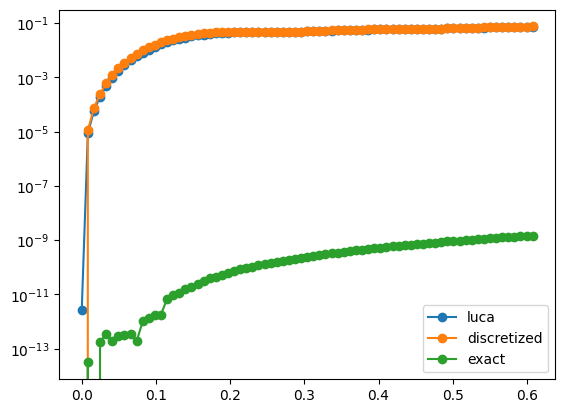

In [6]:
plt.plot(times, midpoint_infidelities, marker='o', label='luca')
plt.plot(times, 1 - bridge.numpy_tools.fidelity(discretized_states, exact_dynamics_states_np[:scaling_factor*(m_states-1)+1:scaling_factor]), marker='o', label='discretized')
plt.plot(times, 1 - bridge.numpy_tools.fidelity(exact_states_from_file, exact_dynamics_states_np[:scaling_factor*(m_states-1)+1:scaling_factor]), marker='o', label='exact')
plt.yscale('log')
plt.legend()

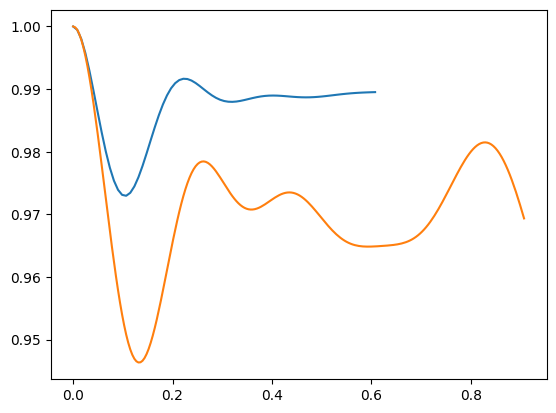

In [7]:
plt.plot(times, midpoint_total_x)
plt.plot(big_times, exact_dynamics_total_x)

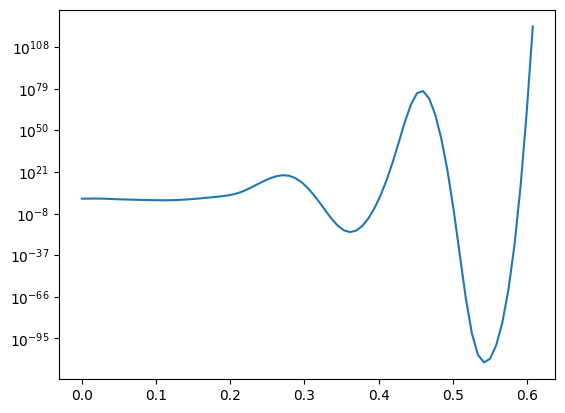

In [8]:
plt.plot(times, np.linalg.norm(base_states_np, axis=1))
plt.yscale('log')

1000 digits!

In [11]:
# Bridge
with nk.utils.timing.timed_scope(force=True) as timer:
    bridge_states, rayleigh_matrix_estimate, info_dict = bridge.bridge(state_list, hamiltonian, big_times, n_samples, sweep_size, n_chains, n_discard_per_chain, chunk_size=1, estimation_method='determinant_state', decimal_precision_solver=1000, discard_imaginary=False, seed=0)

for key in info_dict:
    print(key, info_dict[key])

╭────────────────────────────────────────────── Timing Information ───────────────────────────────────────────────╮
│ Total: 612.076                                                                                                  │
│ ├── (11.4%) | estimate_rayleigh_matrix_determinant_state : 69.738 s                                             │
│ │   ├── (39.4%) | MCState.sample_distribution #5053948238117478327 : 27.497 s                                   │
│ │   │   └── (40.1%) | sampling n_discarded samples : 11.023 s                                                   │
│ │   └── (55.9%) | _expect_rayleigh_matrix_sampled : 38.958 s                                                    │
│ └── (88.6%) | solve_reduced_equation_mp : 542.338 s                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

rme_time 69.73801970481873
eigendecomposition_error 0.0
eigvals_imag 0.

In [13]:
# Infidelity
bridge_states_full = np.inner(bridge_states, base_states_np.T)
bridge_states_infidelities = 1 - bridge.numpy_tools.fidelity(exact_dynamics_states_np, bridge_states_full)
bridge_states_total_x = np.diag((bridge_states_full.conj() @ (total_x.to_sparse() @ bridge_states_full.T))) / np.diag(bridge_states_full.conj() @ bridge_states_full.T)

optimal_infidelities = bridge.distance_to_subspace(exact_dynamics_states_np, base_states_np, decimal_precision=1000)

In [ ]:
log_dict = {'delta': delta,
            'J': J,
            'h': h,
            'h_factor': h_factor,
            'times': times,
            'big_times': big_times,
            'm_states': m_states,
            'n_samples': n_samples,
            'sweep_size': sweep_size,
            'n_chains': n_chains,
            'n_discard_per_chain': n_discard_per_chain,
            'exact_dynamics_total_x': exact_dynamics_total_x,
            'midpoint_infidelities': midpoint_infidelities,
            'midpoint_total_x': midpoint_total_x,
            'bridge_states_infidelities': bridge_states_infidelities,
            'bridge_states_total_x': bridge_states_total_x,
            'optimal_infidelities': optimal_infidelities,
            'discretized_infidelities': discretized_infidelities,
            'discretized_total_x': discretized_total_x,
            'rayleigh_matrix_estimate': rayleigh_matrix_estimate,
            }

log_dict.update(info_dict)

In [ ]:
with open(log_file_name, 'wb') as file:
    pickle.dump(log_dict, file)

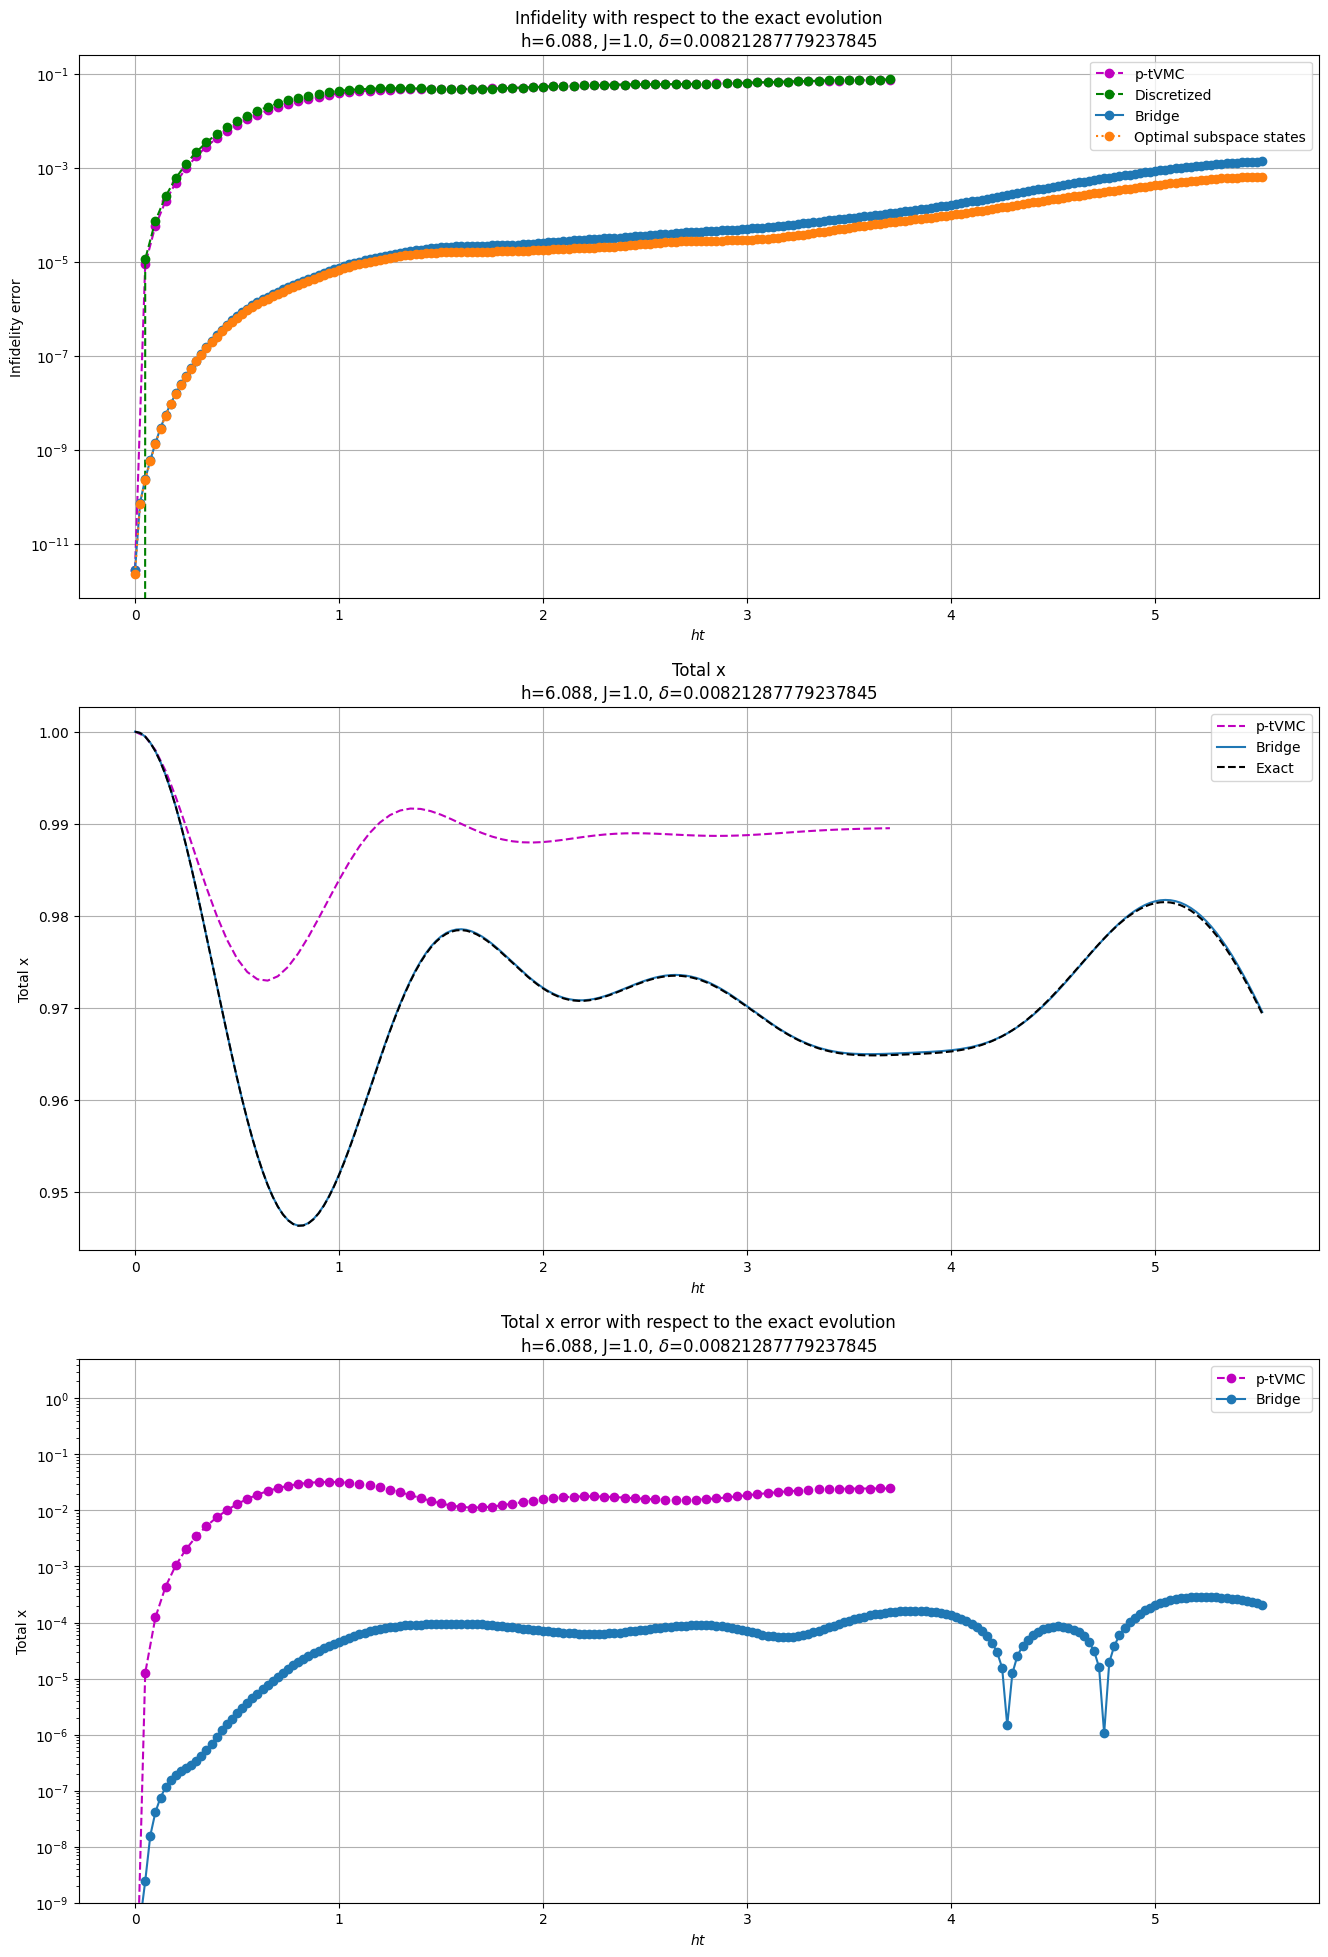

In [16]:
# Plot
fig, ax = plt.subplots(3, 1, figsize=(16, 24))

if h == 0.1 * 3.044:
    x_label = "$J t$"
    times_factor = J

if h == 2 * 3.044:
    x_label = "$h t$"
    times_factor = h


ax[0].plot(times*times_factor, midpoint_infidelities, ls='--', marker='o', c='m', label='p-tVMC')
ax[0].plot(times*times_factor, discretized_infidelities, ls='--', marker='o', c='g', label='Discretized')
ax[0].plot(big_times*times_factor, bridge_states_infidelities, ls='-', marker='o', label='Bridge')
ax[0].plot(big_times*times_factor, optimal_infidelities, ls=':', marker='o', label='Optimal subspace states')

ax[0].set_yscale('log')
ax[0].set_xlabel(x_label)
ax[0].set_ylabel('Infidelity error')
ax[0].set_title('Infidelity with respect to the exact evolution\n'+f'h={h}, J={J}, '+r'$\delta$'+f'={delta}')
ax[0].grid()
ax[0].legend()


ax[1].plot(times*times_factor, midpoint_total_x, ls='--', marker=None, c='m', label='p-tVMC')
ax[1].plot(big_times*times_factor, bridge_states_total_x, ls='-', marker=None, label='Bridge')
ax[1].plot(big_times*times_factor, exact_dynamics_total_x, ls='--', marker=None, c='k', label='Exact')

ax[1].set_xlabel(x_label)
ax[1].set_ylabel('Total x')
ax[1].set_title('Total x\n'+f'h={h}, J={J}, '+r'$\delta$'+f'={delta}')
ax[1].grid()
ax[1].legend()


ax[2].plot(times*times_factor, np.abs(midpoint_total_x - exact_dynamics_total_x[:scaling_factor*(m_states-1)+1:scaling_factor]), ls='--', marker='o', c='m', label='p-tVMC')
ax[2].plot(big_times*times_factor, np.abs(bridge_states_total_x - exact_dynamics_total_x), ls='-', marker='o', label='Bridge')

ax[2].set_yscale('log')
ax[2].set_xlabel(x_label)
ax[2].set_ylabel('Total x')
ax[2].set_title('Total x error with respect to the exact evolution\n'+f'h={h}, J={J}, '+r'$\delta$'+f'={delta}')
ax[2].grid()
ax[2].legend()
ax[2].set_ylim(1e-9, 5)


fig.savefig(log_plot_name)